# Context

* The goal of this assignment is to take a step-by-step approach to solving the credit lending problem on a more realistic data set. 

* In this assignment, we will start from the ETL (Extract, Transform, Load) and data cleaning, followed by building logistic models, and finally, how to produce a credit decision rule. We will also explore variants of the logistic regression

In [1]:
# Data analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Part 1. Data pre-processing 

In [2]:
# Read data by pandas and name it as "loans".

loans = pd.read_csv('lendingclub_full_data_set_no_id.csv')
loans.head(n=10)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,16000,60 months,12.74,361.93,C,C1,Aircraft Maintenance Technician,1 year,MORTGAGE,80000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25000,60 months,28.69,788.84,F,F1,Checker,5 years,MORTGAGE,75200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5000,36 months,5.32,150.58,A,A1,Principal,8 years,RENT,95000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30000,60 months,16.24,733.38,C,C5,Production Supervisor,10+ years,MORTGAGE,72900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7500,36 months,14.49,258.13,C,C4,Director Supplier Management,10+ years,MORTGAGE,180000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20000,60 months,12.79,452.92,C,C1,General Manager,4 years,MORTGAGE,80000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2000,36 months,16.99,71.30,D,D1,material handler,6 years,MORTGAGE,19000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,13000,36 months,11.22,426.96,B,B5,Custodian,< 1 year,RENT,61000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,16000,36 months,13.67,544.29,B,B5,RN,3 years,MORTGAGE,55000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,30000,60 months,9.16,625.09,B,B2,Registered Nurse,3 years,MORTGAGE,114000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Show how many rows and columns such dataset has

loans.shape

(24999, 132)

In [4]:
# list all the unique values of loan status and count the volume of them

loans['loan_status'].value_counts()

Current                                                12063
Fully Paid                                              9733
Charged Off                                             2557
Late (31-120 days)                                       336
In Grace Period                                          174
Late (16-30 days)                                        101
Does not meet the credit policy. Status:Fully Paid        28
Does not meet the credit policy. Status:Charged Off        5
Default                                                    2
Name: loan_status, dtype: int64

In [5]:
# Reset the "loans" dataset by only including the rows whose "loan_status" belongs to one of the following: 
# 'Fully Paid','Late (31-120 days)','Default' and 'Charged Off'

loans = loans[loans["loan_status"].isin(["Fully Paid","Charged Off","Late (31-120 days)","Default"])]
loans = loans.reset_index()
loans.shape

(12628, 133)

In [6]:
# Convert loan status to binary values.
# Rule: A “good” loan = 1 (i.e., positive) and a “bad” loan = 0 (i.e., negative). 
# A good loan means one that is fully paid and a bad one means otherwise.
loans.loc[loans.loan_status != 'Fully Paid', 'loan_status'] = 0
loans.loc[loans.loan_status == 'Fully Paid', 'loan_status'] = 1

loans['loan_status']

0        1
1        0
2        1
3        1
4        1
        ..
12623    1
12624    1
12625    1
12626    0
12627    1
Name: loan_status, Length: 12628, dtype: object

In [7]:
# List again all the unique values of "loan_status" and count the volume of them
loans['loan_status'].value_counts()

1    9733
0    2895
Name: loan_status, dtype: int64

In [8]:
# We consider the following pool of features
    
feature_pool = ['fico_range_high',
 'fico_range_low',
 'acc_now_delinq',
 'installment',
 'collections_12_mths_ex_med',
 'tax_liens',
 'verification_status',
 'revol_bal',
 'home_ownership',
 'total_acc',
 'annual_inc',
 'delinq_2yrs',
 'pub_rec_bankruptcies',
 'purpose',
 'loan_amnt',
 'open_acc',
 'revol_util',
 'sub_grade',
 'delinq_amnt',
 'chargeoff_within_12_mths',
 'inq_last_6mths',
 'pub_rec',
 'term',
 'dti','int_rate',
  'addr_state']

outcome = 'loan_status'

In [9]:
feature_pool.append('loan_status')

In [10]:
# reset "loans" dataset by only including the features in the pool
loans = loans.loc[:,feature_pool]


In [11]:
# List the types of all fields
loans.select_dtypes(exclude=np.number)

,verification_status,home_ownership,purpose,sub_grade,term,addr_state,loan_status
0,Verified,MORTGAGE,debt_consolidation,F1,60 months,GA,1
1,Verified,MORTGAGE,debt_consolidation,C5,60 months,IL,0
2,Not Verified,MORTGAGE,debt_consolidation,C4,36 months,AZ,1
3,Verified,RENT,debt_consolidation,B5,36 months,FL,1
4,Not Verified,MORTGAGE,debt_consolidation,B5,36 months,FL,1
...,...,...,...,...,...,...,...
12623,Not Verified,MORTGAGE,debt_consolidation,C4,36 months,IN,1
12624,Verified,MORTGAGE,debt_consolidation,A3,36 months,OR,1
12625,Source Verified,OWN,debt_consolidation,B5,36 months,TX,1
12626,Source Verified,OWN,debt_consolidation,E1,36 months,OK,0


In [12]:
# For all values of the 'home_ownership' variable that are 'ANY' or 'NONE', rename them to 'OTHER'
loans.loc[loans['home_ownership'].isin(['ANY','NONE']),'home_ownership'] = 'OTHER'

# For all values of the 'purpose' variable that are 'renewable_energy' or 'educational', rename them to 'other'
loans.loc[loans['purpose'].isin(['renewable_energy','educational']),'purpose'] = 'other'

# For all values of the 'sub_grade' variable that are 'G1', 'G2', 'G3', 'G4', or 'G5', rename them to 'G'
loans.loc[loans['sub_grade'].isin(['G1', 'G2', 'G3', 'G4','G5']),'sub_grade'] = 'G'


In [13]:
# For every categorical variable with k alternatives, please replace it with k-1 dummy variables using one-hot encoding.

category_pool = ['home_ownership', 'term', 'sub_grade', 'verification_status','purpose','addr_state']

loans = pd.get_dummies(loans, columns=category_pool, drop_first = True)

In [14]:
# Count the number of features now after transformation
# All fields should be of numerical types by this stage.

print(loans.shape)
loans.select_dtypes(exclude=np.number)

loans["loan_status"] = pd.to_numeric(loans["loan_status"])

(12628, 117)


In [15]:
# Count how many missing values there are in every column of the dataframe loans.

loans.isna().sum()

fico_range_high               0
fico_range_low                0
acc_now_delinq                0
installment                   0
collections_12_mths_ex_med    1
                             ..
addr_state_VT                 0
addr_state_WA                 0
addr_state_WI                 0
addr_state_WV                 0
addr_state_WY                 0
Length: 117, dtype: int64

In [16]:
variables_to_complete = ['tax_liens','revol_util', 'dti', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'pub_rec_bankruptcies']

# Process missing values: use the median value of each field to fill in the missing values
loans['tax_liens'].fillna(loans['tax_liens'].median(), inplace=True)
loans['revol_util'].fillna(loans['revol_util'].median(), inplace=True)
loans['dti'].fillna(loans['dti'].median(), inplace=True)
loans['collections_12_mths_ex_med'].fillna(loans['collections_12_mths_ex_med'].median(), inplace=True)
loans['pub_rec_bankruptcies'].fillna(loans['pub_rec_bankruptcies'].median(), inplace=True)
loans['chargeoff_within_12_mths'].fillna(loans['chargeoff_within_12_mths'].median(), inplace=True)


In [17]:
# check again whether there are any missing values
loans.isna().sum()
loans.isnull().values.any()

False

In [18]:
n = len(loans)
random_index = np.random.RandomState(seed=42).permutation(n)
loans = loans.iloc[random_index]
loans.reset_index(drop=True, inplace=True)

In [19]:
# Split the pre-processed loan data into training, validation and test set
# Suggestion: any deletion of rows could be followed by reset_index to avoid such indexing issues later in the processing
training = loans.iloc[0:7000,:]
validation = loans.iloc[7000:10000,:]
test = loans.iloc[10000:,:]

In [20]:
# Remove target column to create feature only dataset: 'X_train', 'X_val', and 'X_test', respectively 
X_train = training.loc[:, training.columns != 'loan_status']
X_val = validation.loc[:, validation.columns != 'loan_status']
X_test = test.loc[:, test.columns != 'loan_status']

# Keep a copy of the unscaled features using the ".copy()" method, and name them 'X_train_unscale', 'X_val_unscale', and 'X_test_unscale', respectively
X_train_unscale = X_train.copy()
X_val_unscale = X_val.copy()
X_test_unscale = X_test.copy()

# Scale 'X_train', 'X_val', and 'X_test' data using the mean and standard deviation of the training set. 
X_test=(X_test-X_train.mean())/X_train.std()
X_val=(X_val-X_train.mean())/X_train.std()
X_train=(X_train-X_train.mean())/X_train.std()

# Store target column as y-variables in the following datasets: 'y_train', 'y_val', and 'y_test'
y_train = training.loc[:,'loan_status']
y_val = validation.loc[:,'loan_status']
y_test = test.loc[:,'loan_status']



In [21]:
# Print the first five instances for training, validation, and test data sets, respectively, as well as the percentages of all outcome levels

print(X_train.head())
freq = y_train.value_counts()                         
print(freq/sum(freq)*100) 

print(X_val.head())
freq = y_val.value_counts()                         
print(freq/sum(freq)*100) 

print(X_test.head())
freq = y_test.value_counts()                         
print(freq/sum(freq)*100) 


# Print the shapes of the split datasets
print(X_train.shape, y_train.shape, X_val.shape,y_val.shape, X_test.shape, y_test.shape)

# Print the feature names
print(X_train.columns.values)


   fico_range_high  fico_range_low  acc_now_delinq  installment  \
0         0.632298        0.632335       -0.069226    -0.571987   
1        -0.166243       -0.166241       -0.069226    -0.507801   
2        -0.645367       -0.645386       -0.069226     1.713049   
3        -0.325951       -0.325956       -0.069226     0.529051   
4         0.153174        0.153190       -0.069226    -0.764702   

   collections_12_mths_ex_med  tax_liens  revol_bal  total_acc  annual_inc  \
0                   -0.120641  -0.143146  -0.266121  -0.698690   -0.236840   
1                   -0.120641  -0.143146  -0.669710   0.310075   -0.283198   
2                   -0.120641  -0.143146   4.592428   0.562267    1.107559   
3                   -0.120641  -0.143146  -0.536212   2.663861   -0.357372   
4                   -0.120641  -0.143146  -0.039944  -0.446499   -0.487176   

   delinq_2yrs  ...  addr_state_SD  addr_state_TN  addr_state_TX  \
0    -0.361361  ...      -0.041437      -0.126344       -0.2

# Part 2. Predicting with (basic) Logistic Regression 

Let us divide this step into three stage: model training, decision criterion selection, and performance evaluation. The test data should be **only** used in the last stage. 

In [22]:
#Fit a LogisticRegression model using the training data
#Create an instance of logisticregression named lgstc_reg 

lgstc_reg =  LogisticRegression(penalty="none",solver="newton-cg")     

# Fit logististic regression to training set
lgstc_reg.fit(X_train, y_train)                                        # fit training data on logistic regression 

print('The trained coefficients for the logistic regression:')
print(lgstc_reg.intercept_, lgstc_reg.coef_)      
 
type(lgstc_reg.coef_)
n_zeros = np.count_nonzero(lgstc_reg.coef_==0)
print(n_zeros)

The trained coefficients for the logistic regression:
[1.45933399] [[ 2.00962446e+02 -2.00738169e+02 -3.88818743e-02 -6.90345488e-01
  -5.66160527e-03 -7.45412665e-02  7.44755899e-02  2.18458225e-01
   5.98952972e-02 -8.51756694e-02 -8.94470077e-02  6.30713746e-01
  -2.10906335e-01  2.03698345e-02  5.01432950e-02  1.26727962e-02
  -5.67875758e-02  1.32450041e-01 -2.54391361e-01  6.49208659e-01
   4.29522943e-01 -5.27838694e-02 -1.34459606e-01 -4.23678098e-01
  -8.92777648e-02 -9.52126098e-02 -1.92903121e-02 -2.00713058e-01
  -2.23885660e-01 -2.30992503e-01 -2.86845209e-01 -4.03246564e-01
  -4.12501362e-01 -4.44395593e-01 -4.44929796e-01 -5.28814077e-01
  -5.78165455e-01 -5.09350393e-01 -4.74193908e-01 -5.17201690e-01
  -4.62799385e-01 -5.43818834e-01 -4.41615295e-01 -4.75731447e-01
  -4.32240390e-01 -4.54676381e-01 -3.66198973e-01 -4.37507873e-01
  -3.13842003e-01 -3.02194045e-01 -2.89163486e-01 -2.84352154e-01
  -2.38685116e-01 -3.48616260e-01 -3.00153572e-02 -5.12979323e-02
  -1.8120

In [23]:
# Print the average interest rate and loan amount in the unscaled training, validation, and test datasets
print(X_train_unscale['int_rate'].mean())
print(X_val_unscale['int_rate'].mean())
print(X_test_unscale['int_rate'].mean())

print(X_train_unscale['loan_amnt'].mean())
print(X_val_unscale['loan_amnt'].mean())
print(X_test_unscale['loan_amnt'].mean())

13.52306428571454
13.619126666666727
13.498044140030544
14233.028571428571
14311.575
14268.635844748858


In [24]:


def get_data (evaluate_on):
    ###########
    # Get the validation/training data, depending on the data mode
    # Input: evaluate_on is either 'test' or 'validate', meaning whether the evaluation is performed on the validation or test data
    # Output: the appropriate feature and outcome data as a tuple
    ###########
    
    if evaluate_on == 'test':
        X,y,X_unscale = X_test, y_test, X_test_unscale
    elif evaluate_on == 'validate':
        X,y,X_unscale = X_val, y_val, X_val_unscale
    else:
        print('Error: evaluate_on must be either "test" or "validate"')
        X, y, X_unscale  = (None, None, None)
        
    return X,y, X_unscale
    
    

def get_cm (z, reg_model, evaluate_on ):
    
    ###########
    # Get the confusion matrix of given the threshold, classifier and the dataset
    # Input: z is the threshold
    #        reg_model is the sklearn classifier 
    #        evaluate_on is either 'test' or 'validate', meaning whether the confusion matrix is evaluated on the
    #        validation data or test data
    # Output: the confusion matrix
    ###########
    

    # Get the appropriate feature and outcome data    
    X,y, _ = get_data (evaluate_on)
    
    
    # If prob for data set > threshold predict 1
    preds = np.where(reg_model.predict_proba(X)[:,1] > z, 1, 0)                                      
    
    ''' # Print the acceptance rate. Uncomment if needed.
    print('Number of loans accepted: ', np.sum(preds) )
    print('Number of loans rejected: ', np.sum(1-preds) )'''
    
    # create confusion matrix 
    cm = confusion_matrix(y, preds,labels=[1, 0], sample_weight=None) # confusion matrix 
    
    return cm



def get_ratios (cm):
    ###########
    # Get the relavant ratios given a confusion matrix
    # Input: cm is a 2*2 confusion matrix
    # Output: Accuracy, TPR, FNR, TNR, and FPR
    ###########
    
    
    TP = cm[0][0] # True Positives                                                                                          
    FN = cm[0][1] # False Positives                                                                                          
    FP = cm[1][0] # True Negatives                                                                                          
    TN = cm[1][1] # False Negatives                                                                                          
        
    TPR = TP/(TP+FN) # True Positive Rate (sensitivity/recall)                                                                                       
    FNR = FN/(TP+FN) # False Negative Rate (miss rate)                                                                                      
    TNR = TN/(TN+FP) # True Negative Rate (specificity)                                                                                      
    FPR = FP/(TN+FP) # False Positive Rate (fall-out) 
    
    Accuracy = (TP+TN)/(TP+FN+FP+TN)
    
    return Accuracy, TPR, FNR, TNR, FPR



In [25]:
def get_EP (z, reg_model, evaluate_on):
    
    ###########
    # Evaluate the (realized) expected payoff given the threshold, classifier, and based on the validation/test data set
    # Input: z is the threshold
    #        reg_model is a sklearn classifier
    #        evaluate_on is either 'test' or 'validate', meaning whether the confusion matrix is generated from the...
    #        validation data or test data
    # Output: The (realized) expected payff from an average borrower
    # Note: The gain and loss parameters P and L should be estimated from the validation/test data
    ###########
    
    # Get the appropriate feature and outcome data    
    X,y, X_unscale = get_data (evaluate_on)

    cm = get_cm (z, reg_model, evaluate_on)
       
    
    Accuracy, TPR, FNR, TNR, FPR = get_ratios (cm)
    
    frac_p = np.sum(y)/len(y) 
    frac_n = np.sum(1-y)/len(y) 

    P = (X_unscale['int_rate'].mean()) * (X_unscale['loan_amnt'].mean())/100
    L = (X_unscale['loan_amnt'].mean())
    
    EP = P * frac_p * TPR - L * frac_n * FPR 

    return EP




In [26]:


# Let the threshold Z range from 0.5 to 1. 
zrange_default = np.arange(0.5,1,0.001) # a grid search for the threshold 


def EP_curve (reg_model, evaluate_on, zrange = zrange_default):
    
    ###########    
    # Evaluate and plot the (realized) expected payoff curve. Also, we obtain the threshold based on the curve.
    # Input: reg_model is the classifier of interest
    #        evaluate_on is either 'test' or 'validate', 
    #        meaning whether the evaluation is based on validation or test data
    #        zrange is the range that the treshold Z takes value in
    # Output: The optimal threshold
    ###########


    # We calculate the expected payoff as a function of Z
    EP_lr = np.array([get_EP(z, reg_model, evaluate_on = evaluate_on)  for z in zrange]) #The expected payoff curve for the logistic regression
    EP_rg = EP_lr[0] + zrange * (EP_lr[-1] - EP_lr[0]) #The expected payoff curve for the random guess predictor

    plt.plot( zrange, EP_rg,linestyle='--',color = 'black', label='Random Predction')
    plt.plot( zrange , EP_lr,label='Logistic Regression')

    plt.xlabel('Z')
    plt.ylabel('Expected payoff')
    plt.legend()
    plt.show()





    # Analysis of the optimal threshold

    z_optimal = zrange [np.argmax(EP_lr)]

    print('-------------')
    print('The optimal Z is: ', z_optimal)
    print('Evaluated on: the %s data set' %evaluate_on)
    print('   The maximual expected payoff is: ', np.max (EP_lr) )
    print('   The confusion matrix under the optimal Z is: ')
    print(get_cm(z_optimal, reg_model, evaluate_on = evaluate_on))
    Accuracy, TPR, FNR, TNR, FPR = get_ratios (get_cm(z_optimal, reg_model, evaluate_on = evaluate_on))
    print('   The relavant ratios under the optimal Z are: ')
    print('   Accuracy rate:', Accuracy, ' TPR:', TPR, ' FPR:',  FPR)
    print('-------------')
    
    return z_optimal
    

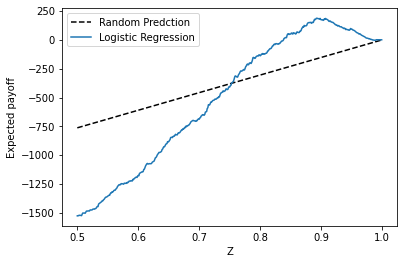

-------------
The optimal Z is:  0.8920000000000003
Evaluated on: the validate data set
   The maximual expected payoff is:  187.4749629880168
   The confusion matrix under the optimal Z is: 
[[ 641 1646]
 [  48  665]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.43533333333333335  TPR: 0.28027984258854394  FPR: 0.06732117812061711
-------------


0.8920000000000003

In [27]:
# Plot the expected payoff curve of the logistic regression model and print 'z_optimal', 
# both based on the validation data

EP_curve(lgstc_reg, 'validate')

In [28]:


def loss_evaluation (reg_model):
    
    # y_train_pred, y_val_pred, and y_test_pred are the predicted probabilities for the training set
    # validation set and test set using the fitted logistic regression model

    y_train_pred=reg_model.predict_proba(X_train)
    y_val_pred=reg_model.predict_proba(X_val)
    y_test_pred=reg_model.predict_proba(X_test)

    # Calculate maximum likelihood for training set, validation set, and test set

    mle_vector_train = np.log(np.where(y_train == 1, y_train_pred[:,1], y_train_pred[:,0]))
    mle_vector_val = np.log(np.where(y_val == 1, y_val_pred[:,1], y_val_pred[:,0]))
    mle_vector_test = np.log(np.where(y_test == 1, y_test_pred[:,1], y_test_pred[:,0]))

    # Calculate loss functions from maximum likelihoods

    loss_function_training = np.negative(np.sum(mle_vector_train)/len(y_train))
    loss_function_val = np.negative(np.sum(mle_vector_val)/len(y_val))
    loss_function_test = np.negative(np.sum(mle_vector_test)/len(y_test))
    
    return loss_function_training, loss_function_val, loss_function_test




In [29]:
# Print the MLE loss function values on training, validation, and test datasets
loss_function_training, loss_function_val, loss_function_test = loss_evaluation(lgstc_reg)
print('Average loss function for training set =', loss_function_training)
print('Average loss function for validation set =', loss_function_val)
print('Average loss function for test set =', loss_function_test)

Average loss function for training set = 0.47261086019699244
Average loss function for validation set = 0.503466329962089
Average loss function for test set = 0.49720208109652037


In [30]:


def get_AUC (reg_model, evaluate_on = 'test'):
    
    ###########
    # Plot the ROC curve of a given classifier and the data to evaluate on. Also, calculate the AUC measure.
    # Input: reg_model is a sklearn classifier 
    #        evaluate_on is either 'test' or 'validate', meaning whether the confusion matrix is evaluated on the
    #        validation data or test data. By default, the ROC curve is evaluated on the test data.
    # Output: The AUC measure. Also, plot the curve.
    ###########
    
    # Get the appropriate feature and outcome data    
    X,y, _ = get_data (evaluate_on)
    
    # Get the predicted probablities from the current model and from random predictions
    model_prob = reg_model.predict_proba(X)
    model_prob = model_prob[:, 1]
    ns_prob=[0 for _ in range(len(y))]
    
    # Get the AUC scores
    ns_auc=roc_auc_score(y, ns_prob)
    model_auc = roc_auc_score(y,model_prob)
    
    
    return model_auc


In [31]:
# Print the AUC measure of the logistic regression on the test data
get_AUC(lgstc_reg, evaluate_on = 'test')



0.6863166241239004

In [32]:
# Evaluate and print the confusion matrix (based on the test data)
get_cm(0.89, lgstc_reg, 'test')


array([[ 596, 1438],
       [  56,  538]], dtype=int64)

* Evaluate the expected payoff of the loan based on the average interest rates and loan amounts

In [33]:
# Evaluate the expected payoff of the loan based on the average interest rates and loan amounts in the test data
get_EP(0.89, lgstc_reg, 'test')


132.74144000711516

# Part 3. Improving the Prediction using Regularization

Let us use L1 regularization to improve the prediction model and ultimately, the loan acceptance decision. 

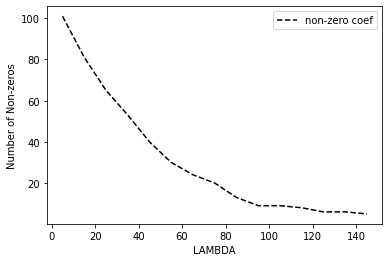

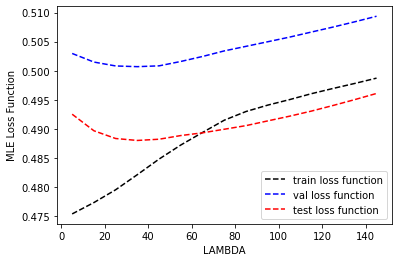

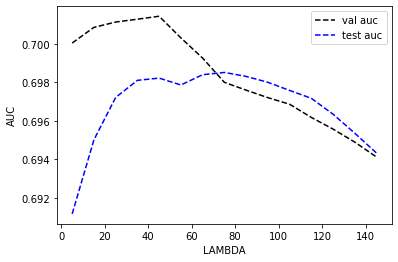

In [34]:
# Let the regularization parameter Lambda range from 5 to 145. (We use LAMBDA to store its range.) 
# For each lambda, fit a logistic regression with L1 regularization. 

# The range of lambda values
LAMBDA = np.arange(5,155, 10)
nzc = []
lf_train = []
lf_val = []
lf_test = []
auc_val = []
auc_test = []

for lam in LAMBDA:
    c = 1/lam
    lgstc_reg =  LogisticRegression(penalty="l1", C = c, solver="liblinear")     

    lgstc_reg.fit(X_train, y_train)                                     

    n_nonzeros = np.count_nonzero(lgstc_reg.coef_)
    nzc.append(n_nonzeros)   
    
    loss_function_training, loss_function_val, loss_function_test = loss_evaluation(lgstc_reg)
    lf_train.append(loss_function_training)
    lf_val.append(loss_function_val)
    lf_test.append(loss_function_test)
    
    auc_val.append(get_AUC(lgstc_reg, evaluate_on = 'validate'))
    auc_test.append(get_AUC(lgstc_reg, evaluate_on = 'test'))
    

    
# Plot the number of non-zero coefficients for the l1-regularized logistic regression as lambda changes
plt.plot( LAMBDA, nzc,linestyle='--',color = 'black', label='non-zero coef')

plt.xlabel('LAMBDA')
plt.ylabel('Number of Non-zeros')
plt.legend()
plt.show()


# Plot the likelihood loss function values (on training, validation, and test data sets) for the l1-regularized logistic regression as lambda changes
plt.plot( LAMBDA, lf_train,linestyle='--',color = 'black', label='train loss function')
plt.plot( LAMBDA, lf_val,linestyle='--',color = 'blue', label='val loss function')
plt.plot( LAMBDA, lf_test,linestyle='--',color = 'red', label='test loss function')

plt.xlabel('LAMBDA')
plt.ylabel('MLE Loss Function')
plt.legend()
plt.show()


# Plot the AUC measures for the l1-regularized logistic regression as lambda changes
plt.plot( LAMBDA, auc_val,linestyle='--',color = 'black', label='val auc')
plt.plot( LAMBDA, auc_test,linestyle='--',color = 'blue', label='test auc')

plt.xlabel('LAMBDA')
plt.ylabel('AUC')
plt.legend()
plt.show()



* Suppose somebody has determined that the optimal regularization parameter is `lambda_optimal` = 40. What is the optimal threshold Z that obtains the highest expected payoff on the **validation** set? 

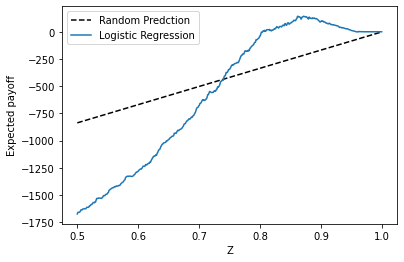

-------------
The optimal Z is:  0.8710000000000003
Evaluated on: the validate data set
   The maximual expected payoff is:  142.6815787951215
   The confusion matrix under the optimal Z is: 
[[ 528 1759]
 [  42  671]]
   The relavant ratios under the optimal Z are: 
   Accuracy rate: 0.39966666666666667  TPR: 0.23087013554875382  FPR: 0.05890603085553997
-------------
0.8710000000000003


In [35]:
# Suppose somebody has determined that the optimal regularization parameter is lambda_optimal = 40. 
lambda_optimal = 40


c = 1/lambda_optimal
lgstc_reg =  LogisticRegression(penalty="l1", C = c, solver="liblinear")
lgstc_reg.fit(X_train, y_train) 
z_optimal_L1 = EP_curve(lgstc_reg, 'validate')
print(z_optimal_L1)


In [36]:



# Print the AUC score of the regualized logistics classifier on the test data
print(get_AUC(lgstc_reg, evaluate_on = 'test'))


# Print the confusion matrix of the regualized logistics classifier on the test data (given the previously chosen threshold 'z_optimal_l1')
print(get_cm(z_optimal_L1, lgstc_reg, 'test'))



# print the expected off on the test data (given the previously chosen threshold 'z_optimal_l1')
print(get_EP(z_optimal_L1, lgstc_reg, 'test'))


0.6984355187403368
[[ 490 1544]
 [  38  556]]
152.78742485034607
